# 学習ループを書いてみよう

ここでは、

1. データセットからデータを取り出す
2. モデルに入力する
3. Optimizerを使ってモデルのパラメータを更新して学習を行うループを回す

ことをやってみます。このノートから得られるものは、`Trainer`を使わない学習ループの書き方です。

## 1. データセットの準備

ここでは、Chainerが用意しているMNISTデータセットを使うための便利なメソッドを利用します。これを使うと、データのダウンロードから、一つ一つのデータを取り出せるようにするところまでが隠蔽されます。

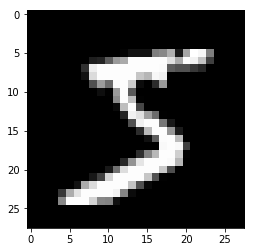

label: 5


In [1]:
from chainer.datasets import mnist

# データセットがダウンロード済みでなければ、ダウンロードも行う
train, test = mnist.get_mnist(withlabel=True, ndim=1)

# matplotlibを使ったグラフ描画結果がnotebook内に表示されるようにします。
%matplotlib inline
import matplotlib.pyplot as plt

# データの例示
x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

## 2. Iteratorの作成

データセットから決まった数のデータを取り出し、それらを束ねてミニバッチを作成して返してくれる`Iterator`を作成しましょう。これをこの後の学習ループの中で使用していきます。イテレータは、`next()`メソッドで新しいミニバッチを返してくれます。内部ではデータセットを何周なめたか（`epoch`）、現在のイテレーションが新しいepochの最初のイテレーションか、などを管理するプロパティ（`is_new_epoch`）などを持っています。

In [2]:
from chainer import iterators

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

### Iteratorについて

- Chainerがいくつか用意しているIteratorの一種である`SerialIterator`は、データセットの中のデータを順番に取り出してくる最もシンプルなIteratorです。
- 引数にデータセットオブジェクトと、バッチサイズを取ります。
- また、このとき渡したデータセットから、何周も何周もデータを繰り返し読み出す必要がある場合は`repeat`引数を`True`とし、1周が終わったらそれ以上データを取り出したくない場合はこれを`False`とします。デフォルトでは、`True`になっています。
- `shuffle`引数に`True`を渡すと、データセットから取り出されてくるデータの順番をエポックごとにランダムに変更します。

ここで、`batchsize = 128`としているので、ここで作成した訓練データ用の`Iterator`である`train_iter`およびテストデータ用の`Iterator`である`test_iter`は、それぞれ128枚の数字画像データを一括りにして返す`Iterator`ということになります。

## 3. モデルの定義

ここでは、シンプルな三層パーセプトロンを定義します。これは全結合層のみからなるネットワークです。中間層のユニット数は適当に100とし、出力は10クラスなので10とします。ここで用いるMNISTデータセットは10種のラベルを持つためです。では、モデルを定義するために必要な`Link`, `Function`, そして`Chain`について、簡単にここで説明を行います。

### LinkとFunction

- Chainerでは、ニューラルネットワークの各層を、`Link`と`Function`に区別します。
- **`Link`は、パラメータを持つ関数です。**
- **`Function`は、パラメータを持たない関数です。**
- これらを組み合わせてモデルを記述します。
- パラメータを持つ層は、`chainer.links`モジュール以下にたくさん用意されています。
- パラメータを持たない層は、`chainer.functions`モジュール以下にたくさん用意されています。
- これらを簡単に使うために、
    ```
    import chainer.links as L
    import chainer.functions as F
    ```
    と別名を与えて、`L.Convolution2D(...)`や`F.relu(...)`のように用いる慣習があります。

### Chain

- Chainは、パラメータを持つ層＝**`Link`をまとめておくためのクラス**です。
- パラメータを持つということは、基本的にモデルの学習の際にそれらを更新していく必要があるということです（例外はあります）。
- そこで、学習中に`Optimizer`が更新すべき全てのパラメータを簡単に取得できるように、`Chain`で一箇所にまとめておきます。

### Chainを継承して定義されるモデル

- モデルは`Chain`クラスを継承したクラスとして定義されることが多いです。
- その場合、モデルを表すクラスのコンストラクタで、親クラスのコンストラクタにキーワード引数の形で登録したい層の名前と、オブジェクトを渡しておくと、自動的に`Optimizer`から見つけられる形で保持しておいてくれます。
- これは、別の場所で`add_link`メソッドを使っても行うことができます。 
- また、関数呼び出しのようにしてモデルに`()`アクセサでデータを渡せるように、`__call__`メソッドを定義して、その中にforward処理を記述すると便利です。

### GPUで実行するには

- `Chain`クラスは`to_gpu`メソッドを持ち、この引数にGPU IDを指定すると、指定したGPU IDのメモリ上にモデルの全パラメータを転送します。
- これはモデル内部でのforward/backward計算をその指定したGPU上で行うために必要になります。
- これを行わない場合、それらの処理はCPU上で行われます。

---

それでは実際にモデルの定義を行い、オブジェクトを作って、GPUに送信してみましょう。

In [4]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        # パラメータを持つ層の登録
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(None, n_mid_units)
            self.l2=L.Linear(None, n_mid_units)
            self.l3=L.Linear(None, n_out)


    def __call__(self, x):
        # データを受け取った際のforward計算を書く
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = -1  # change to -1 if not using GPU

model = MLP()
if gpu_id >= 0:
    model.to_gpu(gpu_id)

### NOTE

ここで、`L.Linear`クラスは全結合層を意味します。コンストラクタの第一引数に`None`を渡すと、実行時に、データがその層に入力された瞬間、必要な数の入力側ユニット数を自動的に計算し、`(n_input)` $\times$ `n_mid_units`の大きさの行列を作成し、パラメータとして保持します。これは後々、畳み込み層を全結合層の前に配置する際などに便利な機能です。

前述のように、`Link`はパラメータを持つので、そのパラメータの値にアクセスすることができます。例えば、上のモデル`MLP`は`l1`という名前の全結合相が登録されています。この全結合相は`W`と`b`という2つのパラメータを持ちます。これらは外からアクセスすることができます。例えば`b`へアクセスするには、以下のようにします。

In [5]:
print('1つ目の全結合相のバイアスパラメータの形は、', model.l1.b.shape)
print('初期化直後のその値は、', model.l1.b.data)

1つ目の全結合相のバイアスパラメータの形は、 (100,)
初期化直後のその値は、 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


## 4. 最適化手法の選択

Chainerは多くの最適化手法を提供しています。`chainer.optimizers`モジュール以下にそれらはあります。ここでは最もシンプルな勾配降下法の手法である`optimizers.SGD`を用います。Optimizerのオブジェクトには、`setup`メソッドを使ってモデル（`Chain`オブジェクト）を渡します。こうすることでOptimizerは、自身が更新すべきモデル内のパラメータを自動的にたどってくれます。

他にもいろいろな最適化手法が手軽に試せるので、色々と試してみて結果の変化を見てみてください。例えば、下の`chainer.optimizers.SGD`のうち`SGD`の部分を`MomentumSGD`, `RMSprop`,  `Adam`などに変えて、結果の違いを見てみましょう。

In [6]:
from chainer import optimizers

optimizer = optimizers.SGD(lr=0.01)
optimizer.setup(model)

### NOTE

今回はSGDのコンストラクタの`lr`という引数に $0.01$ を与えました。この値は学習率として知られ、モデルをうまく訓練して良いパフォーマンスを発揮させるために調整する必要がある重要な**ハイパーパラメータ**として知られています。

## 5. 学習ループ

いよいよ学習ループです。今回は分類問題なので、`softmax_cross_entropy`というロス関数を使って最小化すべきロスの値を計算します。

Chainerでは、`Function`や`Link`を使ってモデルのforward計算を行い、結果と正解ラベルを`Function`の一種でありスカラ値を返すロス関数に渡してやり、ロスの計算を行うと、それは他の`Link`や`Function`と同じく、`Variable`オブジェクトを返します。`Variable`オブジェクトはこれまでの計算過程をあとから逆向きに辿り返すための参照を保持しているため、`Variable.backward`メソッドを呼ぶだけで、自動的にそこからこれまでの計算過程を遡って、途中で施された計算に用いられたパラメータの勾配を計算してくれます。

つまり、学習ループの1回の中で行うのは、以下の4項目です。

1. モデルにデータを渡して出力`y`を得る
2. `y`と正解ラベル`t`を使って、最小化すべきロスの値を`softmax_cross_entropy`関数で計算する
3. `softmax_cross_entropy`関数の出力`Variable`の`backward`メソッドを呼んで、モデル内部のパラメータに`grad`プロパティ（これがパラメータ更新に使われる勾配）を持たせる
4. Optimizerの`update`メソッドを呼び、3.で計算した`grad`を使って全パラメータを更新する

以上です。では実際に訓練ループを書いていきます。

In [9]:
import numpy as np
from chainer.dataset import concat_examples
# from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:
    
    # ---------- 学習の1イテレーション ----------
    train_batch = train_iter.next()
    x, t = concat_examples(train_batch, gpu_id)
    
    # 予測値の計算
    y = model(x)

    # ロスの計算
    loss = F.softmax_cross_entropy(y, t)

    # 勾配の計算
    model.cleargrads()
    loss.backward()

    # パラメータの更新
    optimizer.update()
    # --------------- ここまで ----------------

    # 1エポック終了ごとにValidationデータに対する予測精度を測って、
    # モデルの汎化性能が向上していることをチェックしよう
    if train_iter.is_new_epoch:  # 1 epochが終わったら

        # ロスの表示
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(loss.data)), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            x_test, t_test = concat_examples(test_batch, gpu_id)

            # テストデータをforward
            y_test = model(x_test)

            # ロスを計算
            loss_test = F.softmax_cross_entropy(y_test, t_test)
            test_losses.append(loss_test.data)

            # 精度を計算
            accuracy = F.accuracy(y_test, t_test)
#            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)
            
            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

epoch:03 train_loss:0.3248 val_loss:0.3711 val_accuracy:0.8968
epoch:04 train_loss:0.4059 val_loss:0.3327 val_accuracy:0.9066
epoch:05 train_loss:0.2940 val_loss:0.3076 val_accuracy:0.9112
epoch:06 train_loss:0.3794 val_loss:0.2920 val_accuracy:0.9169
epoch:07 train_loss:0.3427 val_loss:0.2778 val_accuracy:0.9223
epoch:08 train_loss:0.2524 val_loss:0.2649 val_accuracy:0.9257
epoch:09 train_loss:0.2023 val_loss:0.2552 val_accuracy:0.9270
epoch:10 train_loss:0.2375 val_loss:0.2466 val_accuracy:0.9306


## 6. 学習済みモデルを保存する

Chainerには2つのシリアライズ機能が用意されています。一つはHDF5形式でモデルを保存するもので、もう一つはNumPyのNPZ形式でモデルを保存するものです。今回は、追加ライブラリのインストールが必要なHDF5ではなく、NumPy標準機能で提供されているシリアライズ機能を利用したNPZ形式でのモデルの保存を行います。

In [10]:
from chainer import serializers

serializers.save_npz('my_mnist.model', model)

# ちゃんと保存されていることを確認
%ls -la my_mnist.model

-rw-r--r--  1 karaage  staff  333980 10  2 15:49 my_mnist.model


## 7. 保存したモデルを読み込んで推論する

今しがた保存したNPZファイルを読み込んで、テストデータに対して予測を計算させてみます。NPZファイルにはパラメータが保存されているので、forward計算のロジックを持つモデルのオブジェクトをまず作成し、そのパラメータを先程保存したNPZが持つ値で上書きすることで学習直後のモデルの状態を復元します。

In [11]:
# まず同じモデルのオブジェクトを作る
infer_model = MLP()

# そのオブジェクトに保存済みパラメータをロードする
serializers.load_npz('my_mnist.model', infer_model)

# GPU上で計算させるために、モデルをGPUに送る
if gpu_id >= 0:
    infer_model.to_gpu(gpu_id)

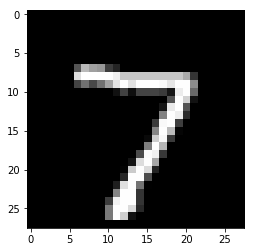

label: 7


In [12]:
# テストデータ
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

In [13]:
# from chainer.cuda import to_gpu

# ミニバッチの形にする（ここではサイズ1のミニバッチにするが、
# 複数まとめてサイズnのミニバッチにしてまとめて推論することもできる）
print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

# GPU上で計算させるため、データもGPU上に送る
if gpu_id >= 0:
    x = to_gpu(x, 0)

# モデルのforward関数に渡す
y = infer_model(x)

# Variable形式で出てくるので中身を取り出す
y = y.data

# 結果をCPUに送る
# y = to_cpu(y)

# 最大値のインデックスを見る
pred_label = y.argmax(axis=1)

print('predicted label:', pred_label[0])

(784,) -> (1, 784)
predicted label: 7
